In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

import numpy as np

Using TensorFlow backend.
/Users/mbp2016/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
img_shape = (28, 28, 1)
batch_size = 16

latent_dim = 2

In [3]:
# encoder
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def sampling(args):
    z_mean, z_log_var = args

    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

In [5]:
# decoder
decoder_input = keras.Input(shape=K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
encoder = Model(input_img, z)
z_decoded = decoder(z)

https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
The KL divergence from  y^  to  y  is simply the difference between cross entropy and entropy:

In [6]:
def vae_loss(x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    return K.mean(xent_loss + kl_loss)

In [7]:
vae = Model(input_img, z_decoded)

In [8]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [9]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [10]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

In [11]:
vae.fit(x_train, x_train, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, x_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 298s 5ms/step - loss: 0.2111 - val_loss: 0.1979
Epoch 2/10
60000/60000 [==============================] - 299s 5ms/step - loss: 0.1928 - val_loss: 0.1900
Epoch 3/10
60000/60000 [==============================] - 310s 5ms/step - loss: 0.1883 - val_loss: 0.1888
Epoch 4/10
60000/60000 [==============================] - 303s 5ms/step - loss: 0.1859 - val_loss: 0.1854
Epoch 5/10
60000/60000 [==============================] - 305s 5ms/step - loss: 0.1842 - val_loss: 0.1837
Epoch 6/10
60000/60000 [==============================] - 312s 5ms/step - loss: 0.1831 - val_loss: 0.1839
Epoch 7/10
60000/60000 [==============================] - 314s 5ms/step - loss: 0.1821 - val_loss: 0.1819
Epoch 8/10
60000/60000 [==============================] - 313s 5ms/step - loss: 0.1814 - val_loss: 0.1824
Epoch 9/10
60000/60000 [==============================] - 302s 5ms/step - loss: 0.1808 - val_loss: 0.1

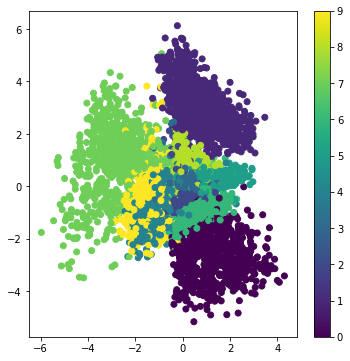

In [12]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

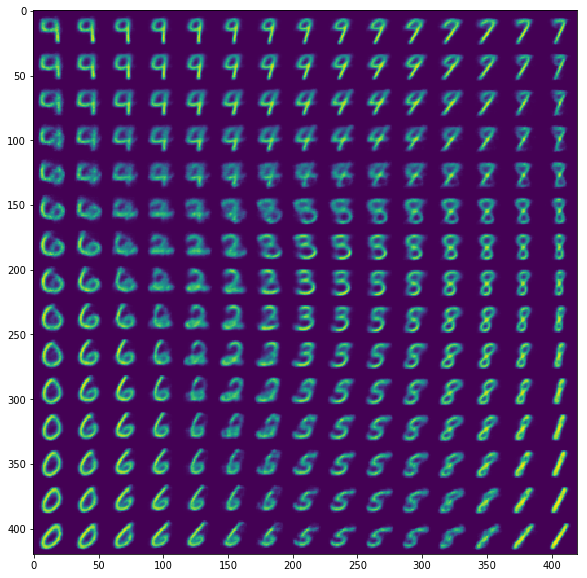

In [13]:
from scipy.stats import norm

n =15
digit_size = 28
fig = np.zeros((digit_size*n, digit_size*n))
grid_x=norm.ppf(np.linspace(0.05, 0.95, n))
grid_y=norm.ppf(np.linspace(0.05, 0.95, n))
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded.reshape(digit_size, digit_size)
        fig[i*digit_size:(i+1)*digit_size,
              j*digit_size:(j+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(fig)
plt.show()